# Runtime & State -> 컨텐스트 엔지니어링에 필요한 필수 지식

- GPT는 12만8천 토큰이다.
- Runtime과 State를 이용해야 언어모델이 가지고 있는 컨텍스트윈도우에 적절한 내용을 채울 수 있다.
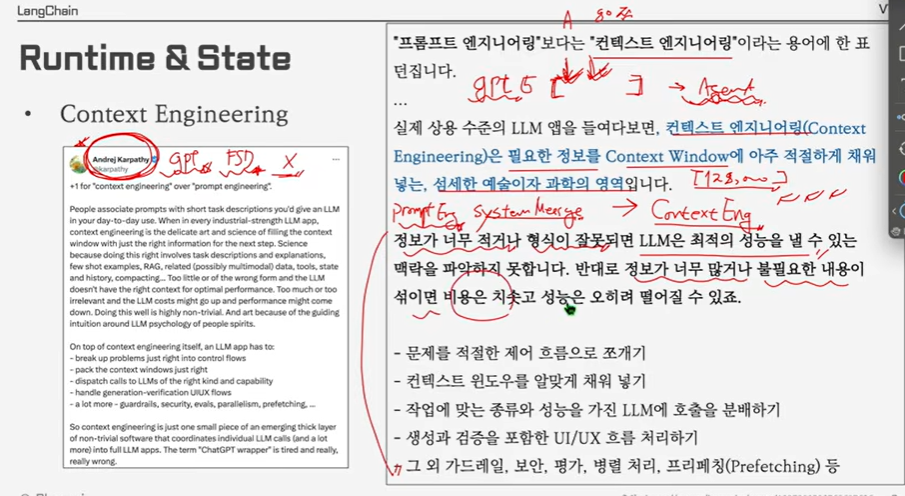

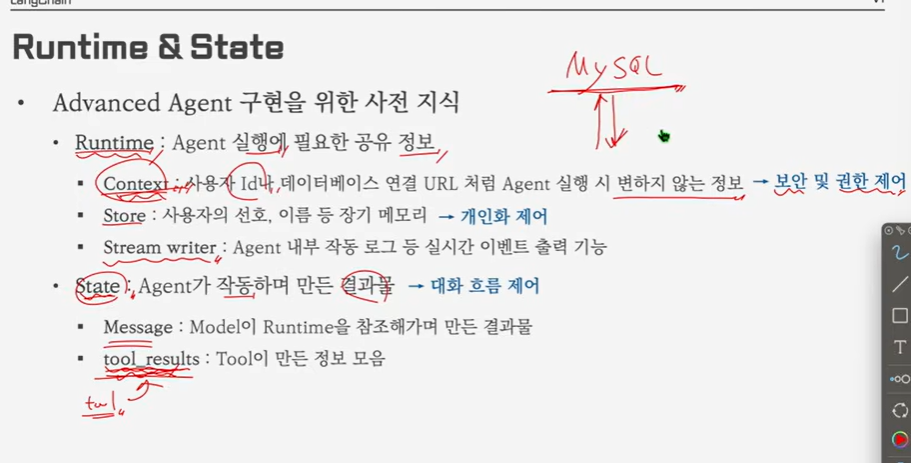

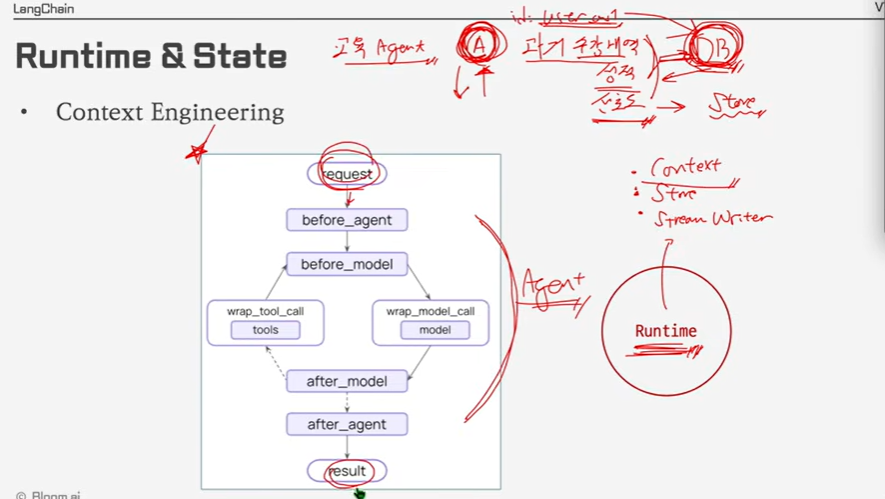

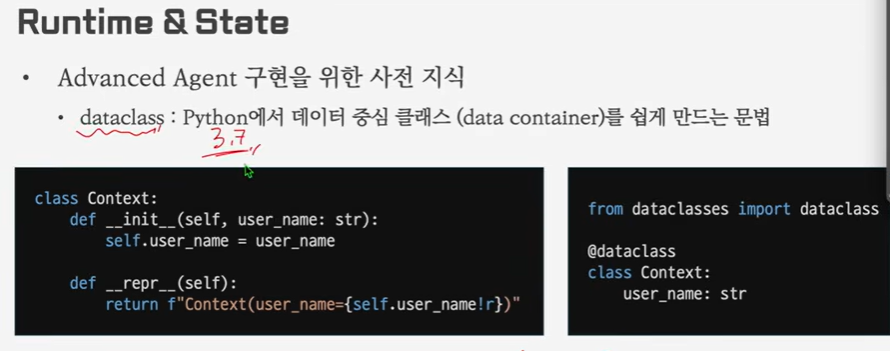

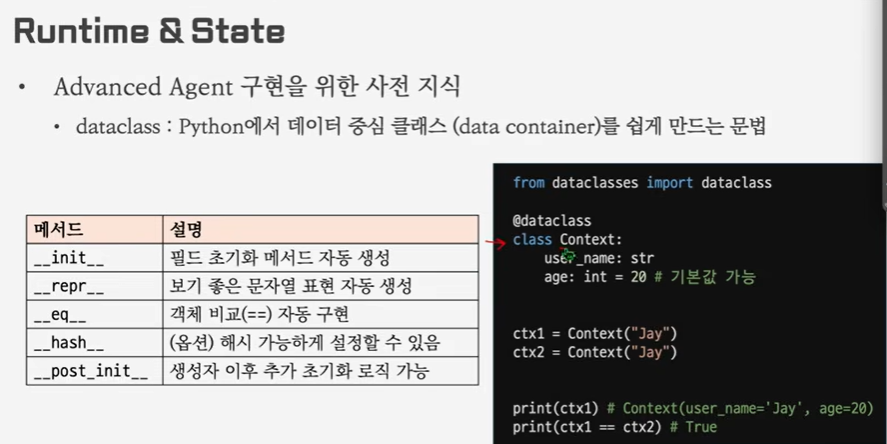

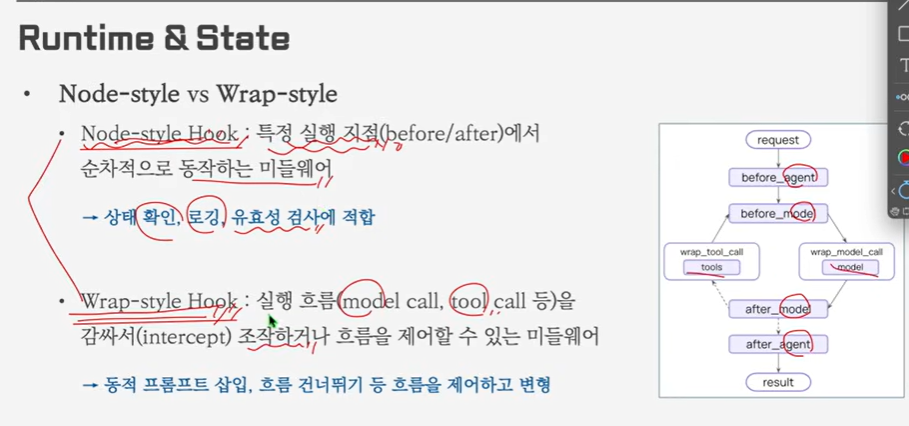

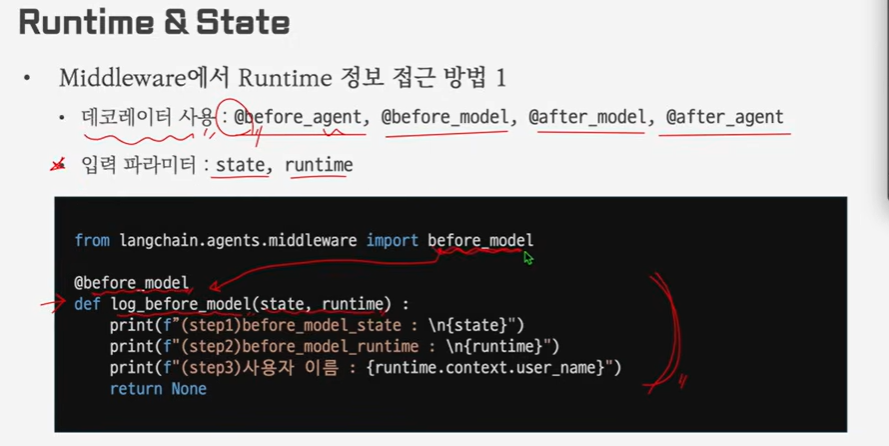

### node-style 훅
- dataclass
- 단순히 로깅용이다!, 모니터링 할때 사용

In [36]:
import os
from dotenv import load_dotenv
from dataclasses import dataclass
from langchain.chat_models import init_chat_model

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

model = init_chat_model(api_key=api_key,
                        model="gpt-5-nano")

@dataclass
class Context:
    user_nm : str

from langchain.agents.middleware import before_model

@before_model
def log_before_model(state, runtime):
    print(f"(step1)before_model_state : \n{state}")
    print(f"(step2)before_model_runtime : \n{runtime}")
    print(f"(step3)사용자 이름 : \n{runtime.context.user_nm}")
    return None

In [38]:
from langchain.agents import create_agent

agent=create_agent(
    model="gpt-5-mini",
    tools=[],
    middleware=[log_before_model],
    context_schema=Context,
)

agent.invoke(
    {"messages":[{"role":"user", "content":"내 이름이 뭐냐?"}]},
    context=Context(user_nm="john smith")
)

(step1)before_model_state : 
{'messages': [HumanMessage(content='내 이름이 뭐냐?', additional_kwargs={}, response_metadata={}, id='3c1c589a-1b5d-46e7-ac59-c33e77e1425f')]}
(step2)before_model_runtime : 
Runtime(context=Context(user_nm='john smith'), store=None, stream_writer=<function Pregel.stream.<locals>.stream_writer at 0x00000150654F4400>, previous=None)
(step3)사용자 이름 : 
john smith


{'messages': [HumanMessage(content='내 이름이 뭐냐?', additional_kwargs={}, response_metadata={}, id='3c1c589a-1b5d-46e7-ac59-c33e77e1425f'),
  AIMessage(content='지금은 당신의 이름을 알지 못해요 — 저는 개인 정보에 접근할 수 없고, 사용자가 직접 알려주지 않으면 이름을 알 수 없습니다. \n\n이름을 알려주실래요? 이 대화에서는 알려주시면 그 이름으로 불러 드릴게요. (다음에 다시 대화할 땐 다시 알려 주셔야 합니다.)  \n원하시면 정중하게 “님”을 붙여 부르거나, 반말/친근한 호칭으로 부르는 등 어떻게 부를지 선택해 주세요. 혹은 별명 하나 만들어 드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 586, 'prompt_tokens': 12, 'total_tokens': 598, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CuYdDfCXEPqfGT0N9jrscoZGaCdoG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b8ce7-4dac-75f0-9d2b-5b9efc33b1a5-0

# Wrap-style 훅
- 입력 파라미터에 request와 handler가 필요하다
- handler는 request를 llm에 보내는 버튼 역할
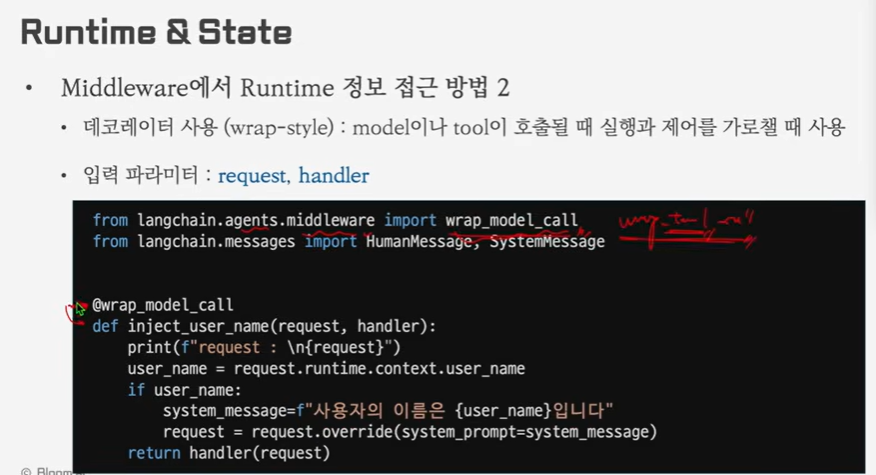

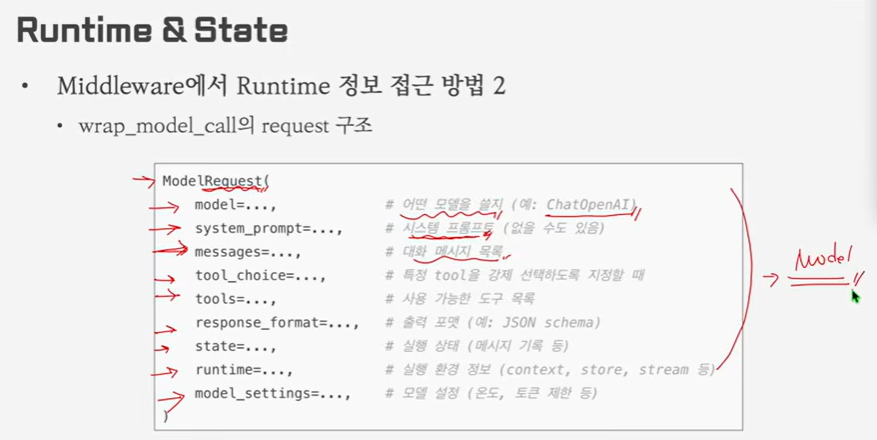

In [40]:
from langchain.agents.middleware import wrap_model_call
from langchain.messages import HumanMessage, SystemMessage

@wrap_model_call
def inject_user_name(request, handler):
    print(f"request : \n{request}")
    # user_nm = request.runtime.context.user_nm
    # if user_nm:
    #     system_message=f"사용자의 이름은 {user_nm}입니덩"
    #     request = request.override(system_pr=system_message)

    return handler(request)

In [41]:
from langchain.agents.middleware import after_model

@after_model
def log_after_model(state, runtime):
    print(f"모델 응답 완료 후 : {state['messages'][-1].content}")
    return None

In [43]:
agent = create_agent(
    model = "gpt-5-mini",
    middleware=[inject_user_name, log_after_model],
    tools=[],
    context_schema=Context,
)

In [47]:
response = agent.invoke({
    "messages":[{"role":"user","content":"내 이름이 뭐니?"},]},
    context=Context(user_nm="huchu")
)

request : 
ModelRequest(model=ChatOpenAI(profile={'max_input_tokens': 272000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000015063DDE3C0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000015065513290>, root_client=<openai.OpenAI object at 0x0000015063DDEDE0>, root_async_client=<openai.AsyncOpenAI object at 0x0000015063DDEEA0>, model_name='gpt-5-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), messages=[HumanMessage(content='내 이름이 뭐니?', additional_kwargs={}, response_metadata={}, id='e1bd4a17-233a-4f47-aa90-9bb372

In [48]:
print(response)

{'messages': [HumanMessage(content='내 이름이 뭐니?', additional_kwargs={}, response_metadata={}, id='e1bd4a17-233a-4f47-aa90-9bb372591ef6'), AIMessage(content='지금 이 대화만으로는 당신의 이름을 알 수 없어요. 이름을 알려주시면 이 채팅에서는 그 이름으로 불러드릴게요.  \n원하시면 실명·별명·호칭(님/씨/반말 등) 중 어떻게 부를지도 알려주세요. 개인정보 공유에 유의해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 402, 'prompt_tokens': 12, 'total_tokens': 414, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CuYw7fbkc4ajRI3qkcc2Jba1a5ie5', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b8cf9-2e05-74a0-a1b5-57d98187ceb6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 402, 'total_tokens': 414, 'input_token_details': {